# E10-3: A multi-resolution sinusoidal model

In this exercise you will implement a multi-resolution sine model by modifying the `sineModel()` function. 

You have seen through several assignments that the choice of window size is an important tradeoff between time and frequency resolution. Longer windows have a better frequency resolution and can resolve two close sinusoids even at low frequencies, while smaller windows have a better time resolution leading to sharper onsets. So far, in all the analyses, we have only considered a single window length over the whole sound. As we know, analysis of signals with low frequency components needs longer windows as compared to signals with high frequency content. The optimal choice of window length is thus dependent on the frequency content of the signal. In other words, it is better to choose a longer window for the analysis of the low frequencies while a shorter window is sufficient for higher frequencies. In this exercise, you will explore the use of multiple window sizes for analysis in different frequency bands of the signals, what is called multi-resolution.

For each audio frame of `x` you should compute three different DFTs with three different window sizes and find the sinusoidal peaks for each of the DFTs. For example, you can choose window sizes `M1 = 4095, M2 = 2047, M3 = 1023`, to generate three windows w1, w2, w3. Choose N1, N2, N3 to be the power of two bigger than the corresponding window size. Then compute the spectra, `X1`, `X2`, and `X3` using `dftAnal()`. Define the frequency bands like `B1: 0 <= f < 1000Hz, B2: 1000 <= f < 5000, B3: 5000 <= f < 22050` and find the peaks of `B1` in `X1`, the ones of `B2` in `X2`, and the ones of `B3` in `X3`. From the peaks we finally re-synthesize the frame and generate the output `y`. 

Complete `sineModelMultiRes()`, by copiying and modifying the code from `SineModel()`. The functions should take as input three windows with different sizes, three FFT sizes, and the values for the frequency bands. Write the code to implement the multi-resolution analysis as described above.

Choose two different polyphonic recordings from freesound that have both a relevant melodic and percussion components. Edit them and change their format as needed. Choose suitable set of parameters for their analysis. Experiment with different window sizes and fruequency bands for the two sounds such that you get both crisp onsets and good frequency resolution. Get the best posible base line reconstruction with `SineModel()` and the best with `sineModelMultiRes()`. Listen the sounds and visualize the information that might be needed to undertand the process. 

Your explanation should include:

1. Freesound link to the two sounds chosen.
2. Explanation and justification of the band edges and the window sizes for each sound.
3. Observations about the advantages of a multi-resolution analysis (comment on the time-frequency resolution, computational complexity and extensions to HPR and HPS models).
4. Challenges you might face if you were to extend it to HPR and HPS models (mainly in sinusoid tracking and F0 estimation).
5. Further methods to improving the time-frequency resolution trade-off. 


In [1]:
import sys, os
from scipy.signal import get_window
import numpy as np
from scipy.signal import blackmanharris, triang
from scipy.fftpack import ifft, fftshift
import math
sys.path.append('../software/models/')
import dftModel as DFT
import utilFunctions as UF
import dftModel as DFT
import utilFunctions as UF
import sineModel as SM
import IPython.display as ipd
import matplotlib.pyplot as plt

In [28]:
def sineModelMultiRes(x, fs, W, N, t, B):
    """
    Analysis/synthesis of a sound using the sinusoidal model, without sine tracking
    Inputs:
        x: input array sound
        w: 3 analysis windows
        t: threshold in negative dB 
        B: 3 frequency boundaries
    Output:
        y: output array sound
    """
 
### your code here, start from copying the code from sineModel()       
        
    hM1 = int(math.floor((W[0].size+1)/2))                     # half analysis window size by rounding
    hM2 = int(math.floor(W[0].size/2))                         # half analysis window size by floor
    Ns = 512                                                # FFT size for synthesis (even)
    H = Ns//4                                               # Hop size used for analysis and synthesis
    hNs = Ns//2                                             # half of synthesis FFT size
    pin = max(hNs, hM1)                                     # init sound pointer in middle of anal window       
    pend = x.size - max(hNs, hM1)                           # last sample to start a frame
    yw = np.zeros(Ns)                                       # initialize output sound frame
    y = np.zeros(x.size)                                    # initialize output array
    sw = np.zeros(Ns)                                       # initialize synthesis window
    ow = triang(2*H)                                        # triangular window
    sw[hNs-H:hNs+H] = ow                                    # add triangular window
    bh = blackmanharris(Ns)                                 # blackmanharris window
    bh = bh / sum(bh)                                       # normalized blackmanharris window
    sw[hNs-H:hNs+H] = sw[hNs-H:hNs+H] / bh[hNs-H:hNs+H]     # normalized synthesis window


    while pin<pend:
        
        # while input sound pointer is within sound 
        ipfreq_tot = np.array([])
        ipmag_tot = np.array([])
        ipphase_tot = np.array([])
        
        for i in range (0,B.size-1):   
            
        
            hM1 = int(math.floor((W[i].size+1)/2))               # half analysis window size by rounding
            hM2 = int(math.floor(W[i].size/2))                   # half analysis window size by floor
            w = W[i]/sum(W[i])                                   # normalize analysis window   
            
        #-----analysis-----#             
            x1 = x[pin-hM1:pin+hM2]                               # select frame
            mX, pX = DFT.dftAnal(x1, w, N[i])                        # compute dft     

            ploc = UF.peakDetection(mX, t)                        # detect locations of peaks
            iploc, ipmag, ipphase = UF.peakInterp(mX, pX, ploc)   # refine peak values by interpolation
            ipfreq = fs*iploc/float(N[i])                         # convert peak locations to Hertz

            if(len(np.where(B[i]>ipfreq)[0] > 0)):      #identify first frequency of the band in the array (ilow)
                ilow = min(np.where(B[i]<ipfreq)[0])
            else:
                ilow = 0
            ihigh = max(np.where(B[i+1]>ipfreq)[0])   #identify last frequency of the band in the array (ihigh)

            ipfreq = ipfreq[ilow:ihigh]
            ipmag = ipmag[ilow:ihigh]
            ipphase = ipphase[ilow:ihigh]

            ipfreq_tot = np.append(ipfreq_tot,ipfreq)
            ipmag_tot = np.append(ipmag_tot,ipmag)
            ipphase_tot = np.append(ipphase_tot,ipphase)        

    #-----synthesis-----#
        Y = UF.genSpecSines(ipfreq_tot, ipmag_tot, ipphase_tot, Ns, fs)   # generate sines in the spectrum  
        fftbuffer = np.real(ifft(Y))                          # compute inverse FFT
        yw[:hNs-1] = fftbuffer[hNs+1:]                        # undo zero-phase window
        yw[hNs-1:] = fftbuffer[:hNs+1] 
        y[pin-hNs:pin+hNs] += sw*yw                           # overlap-add and apply a synthesis window
        pin += H                                              # advance sound pointer

    return y


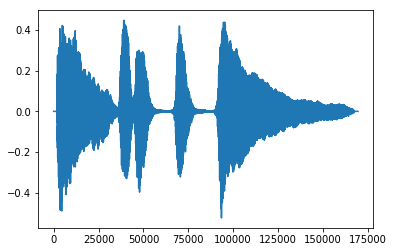

In [5]:
# base line sinusoidal analysis/synthesis
### set the parameters
input_file = '../sounds/piano.wav'
M = 4095
N = 4096
t = -100
window = 'blackman'

# no need to change code from here
fs, x = UF.wavread(input_file) 
w = get_window(window, M) 
y = SM.sineModel(x, fs, w, N, t)

plt.figure()
plt.plot(y)


ipd.display(ipd.Audio(data=x, rate=fs))
ipd.display(ipd.Audio(data=y, rate=fs))

In [29]:
# multiresolution sinusoidal analysis/synthesis
### set the parameters
input_file = '../sounds/piano.wav'
M = np.array([4095,2047,1023])
N = np.array([4096,2048,1024])
B = np.array([0,1000,5000,20050])
t = -100
window = 'blackman'

fs, x = UF.wavread(input_file) 

w1 = get_window(window, M[0])
w2 = get_window(window, M[1])
w3 = get_window(window, M[2])

w = [w1, w2, w3]

# no need to change code from here
y = sineModelMultiRes(x, fs, w, N, t, B)
ipd.display(ipd.Audio(data=y, rate=fs))

## Your explanation

